<a href="https://colab.research.google.com/github/niteshctrl/ObjectDetection/blob/test/YOLOv3_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/datasets/yolo/

/content/drive/MyDrive/datasets/yolo


In [ ]:
# Download Weights

!wget https://pjreddie.com/media/files/yolov3.weights

--2021-06-09 05:17:32--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  67.2MB/s    in 3.7s    

2021-06-09 05:17:36 (63.3 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [4]:
import struct
import numpy as np
from numpy import expand_dims
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from tensorflow.math import sigmoid
from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, ZeroPadding2D, UpSampling2D

from keras.layers.merge import add, concatenate

# Build the Model

In [ ]:
def _conv_block(base, convs, skip=True):
    x = base
    count = 0
    for conv in convs:

        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1

        if conv['stride'] > 1:
            x = ZeroPadding2D(((1,0),(1,0)))(x) #((top_pad, bottom_pad), (left_pad, right_pad))

        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same',
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)

        if conv['bnorm']:
            x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)

        if conv['leaky']:
            x = LeakyReLU(alpha=0.1, name='leaky_'+str(conv['layer_idx']))(x)

    return add([skip_connection, x]) if skip else x

In [ ]:
def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

In [ ]:
class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')
 
	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]
 
	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))
 
	def reset(self):
		self.offset = 0

In [ ]:
model = make_yolov3_model()

weight_reader = WeightReader('yolov3.weights')
weight_reader.load_weights(model)
model.save('model.h5')

# Predictions and Post-processing

In [5]:
# Load model
model = load_model('model.h5')

In [43]:
# Define the anchor boxes
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
image_file = 'image1.jpg' # Path of the image
model_input_width, model_input_height = 416, 416 # Width, Height

# Define the probability threshold for detected objects
class_threshold = 0.6


'''We need a list of strings containing the class labels known to the model
 in the correct order used during training, specifically those class labels
  from the MSCOCO dataset. Thankfully, this is provided in the experiencor
  script.'''

# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
    "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
    "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
    "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
    "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
    "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
    "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
    "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
    "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

print("Total number of classes = {}".format(len(labels)))

Total number of classes = 80


In [44]:
# Image prep function

def preprocess_image(filename, target_shape):
    '''
    Processes the given image to feed the model(Rescaling by factor 1./255 and
    resizing to target_shape)

    Arguments:
    filename -- Filepath of the image to be processed
    target_shape -- Shape of the image accepted by the model

    Returns:
    image -- Array of the resized input image to target_size
    width -- Original width of the image
    height -- Original height of the image
    '''
    image = load_img(filename)
    width, height = image.size

    image = load_img(filename, target_size=target_shape)
    image = img_to_array(image)
    image /= 255.0
    image = expand_dims(image, 0)

    return image, width, height

In [45]:
# Get rescaled image

image_array, orignial_img_width, orignial_img_height = preprocess_image(image_file, 
                                                                  (model_input_width,
                                                                   model_input_height))
image_array

array([[[[0.22352941, 0.26666668, 0.44313726],
         [0.23137255, 0.28235295, 0.41960785],
         [0.21960784, 0.27450982, 0.38039216],
         ...,
         [0.39607844, 0.39607844, 0.3647059 ],
         [0.43137255, 0.42745098, 0.40784314],
         [0.5137255 , 0.50980395, 0.49411765]],

        [[0.14509805, 0.1764706 , 0.36862746],
         [0.13333334, 0.16470589, 0.34509805],
         [0.13725491, 0.17254902, 0.3254902 ],
         ...,
         [0.44705883, 0.44705883, 0.4392157 ],
         [0.48235294, 0.48235294, 0.48235294],
         [0.54901963, 0.54901963, 0.5568628 ]],

        [[0.70980394, 0.7372549 , 0.9098039 ],
         [0.39215687, 0.41960785, 0.5921569 ],
         [0.23529412, 0.2627451 , 0.43529412],
         ...,
         [0.7058824 , 0.7019608 , 0.72156864],
         [0.7647059 , 0.7607843 , 0.78431374],
         [0.85490197, 0.84705883, 0.8901961 ]],

        ...,

        [[0.31764707, 0.29803923, 0.3254902 ],
         [0.38039216, 0.36078432, 0.3882353 ]

In [46]:
# Make prediction
yhat = model.predict(image_array)

# summarize the shape of the prediction
print("Type = {}\n{}".format(type(yhat), [a.shape for a in yhat]))

Type = <class 'list'>
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


In [47]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1

    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        return self.label

    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        return self.score
        
'''decode_netout() will take each one of the NumPy arrays, one at a time, and
decode the candidate bounding boxes and class predictions. Further, any bounding
boxes that don’t confidently describe an object (e.g. all class probabilities
are below a threshold) are ignored. We will use a probability of 60% or 0.6. The
function returns a list of BoundBox instances that define the corners of each 
bounding box in the context of the input image shape and class probabilities.'''

'''def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 '''

def decode_netout(netout, anchors, obj_threshold, net_h, net_w):
    grid_h, grid_w = netout.shape[:2] # Number of Grid divisions
    nb_box = 3 # Number of anchor boxes
    netout = netout.reshape((grid_h, grid_w, nb_box, -1)) # Convert (13,13,225) to (13,13,3,85)
    nb_classes = netout.shape[-1] - 5 # 5 dedected due to pc, bx, by, bh, bw
    boxes = []

    netout[..., :2] = sigmoid(netout[..., :2])
    netout[..., 4:] = sigmoid(netout[..., 4:])
    netout[..., 5:] = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_threshold

    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w

        for b in range(nb_box):
            objectness = netout[int(row)][int(col)][b][4]
            if objectness.all() <= obj_threshold:
                continue
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w
            y = (row + y) / grid_h
            w = anchors[2 * b + 0] * np.exp(w) / net_w
            h = anchors[2 * b + 1] * np.exp(h) / net_h

            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes

In [48]:
# Decode the output of the network


boxes = list()
for i in range(len(yhat)):
    boxes += decode_netout(yhat[i][0], 
                           anchors[i], 
                           class_threshold, 
                           model_input_height,
                           model_input_width
                           )
    
print(boxes[0].xmin, boxes[10].ymax)

-0.15580477164341855 0.29563763671549115


In [49]:
# To rescale the bboxes to fit on the objects of the original image

def rescale_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [50]:
# Resize the predicted bboxes to fit the original iamge

rescale_yolo_boxes(boxes, 
                   orignial_img_height,
                   orignial_img_width,
                   model_input_height, 
                   model_input_width
                   )

print(boxes[0].xmin, boxes[10].ymax)

-99 141


In [51]:
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

def do_nms(boxes, nms_threshold):
    if len(boxes) > 0:
        nb_classes = len(boxes[0].classes)
    else:
        return

    for c in range(nb_classes):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0:
                continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
                    boxes[index_j].classes[c] = 0

In [52]:
# Supress non-max boxes

do_nms(boxes, 0.5)
print(len(boxes),boxes[0].xmin, boxes[10].ymax)

10647 -99 141


In [53]:
def filter_boxes(boxes, labels, threshold=0.6):
    v_boxes, v_labels, v_scores = list(), list(), list()
    
    for box in boxes:
        for i in range(len(labels)):
            if box.classes[i] > threshold:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
    return v_boxes, v_labels, v_scores

print(len(v_boxes),v_boxes[0].xmin, v_boxes[0].ymax)

10 343 476


In [54]:
# Get the details of the detected objects
v_boxes, v_labels, v_scores = filter_boxes(boxes, labels, class_threshold)


# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])

person 99.28438067436218
person 99.47402477264404
person 70.80206274986267
person 83.51122736930847
person 75.05325675010681
person 99.85968470573425
person 99.78912472724915
person 99.8994767665863
person 99.60952401161194
person 97.646564245224


In [55]:
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = pyplot.imread(filename)
    # plot the image
    pyplot.imshow(data)
    
    ax = pyplot.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        width, height = x2 - x1, y2 - y1
        rect = Rectangle((x1,y1), width, height, fill=False, color='white')
        ax.add_patch(rect)
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        pyplot.text(x1, y1, label, color='white')
    pyplot.show()

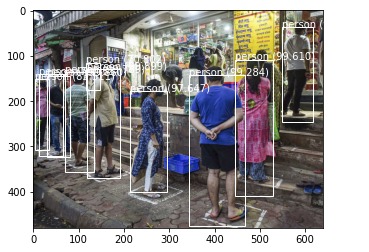

In [56]:
draw_boxes(image_file, v_boxes, v_labels, v_scores)